In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict, List
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AnyMessage
import operator

In [3]:
model = AzureChatOpenAI(openai_api_version=os.environ.get("AZURE_OPENAI_VERSION", "2023-07-01-preview"),
    azure_deployment=os.environ.get("AZURE_OPENAI_DEPLOYMENT", "gpt4chat"),
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT", "https://gpt-4-trails.openai.azure.com/"),
    api_key=os.environ.get("AZURE_OPENAI_KEY"))

In [4]:
class AgentState(TypedDict):
    # user_preferences: dict # This is the user_preferences
    risk: str # This is the human input, can be high, low and moderate
    investment_amount: float # This is the human input can be any number
    investment_time: str # This is human input ex:- 5 years
    specific_sectors: List[str] # These can be tech, healthcare etc
    market_analysis: str # This is the analysis generated by the market analyzer agent
    stock_screener: str # This is the draft generated by the stock screener agent consists of different stocks based on user profile
    risk_assessor: str # This is the report generated by the risk assessor agent
    performance_predictor: str # This is the analysis genereated by the preformance predictor agent
    report_generator: str # This is the final report
    content: List[str] # This is the list of documents that tavily has returned

In [5]:
MARKET_ANALYSIS_PROMPT = """You are an expert market analyst tasked to analyse the current market conditions and tasks.\
    using the Tavily API for search"""

In [6]:
STOCK_SCREENER_PROMPT = """You specialize in finding the best stocks by using the market analysis agent. \
"""

In [7]:
RISK_ASSESSOR_PROMPT = """Evaluate the risk associated with potential stock picks.\
You are adept at assessing risks, ensuring that investments align with the user's risk tolerance.\
"""

In [8]:
PERFORMANCE_PREDICTOR_PROMPT = """Your expertise lies in predicting stock performance using historical data and current trends. \
"""

In [9]:
REPORT_GENERATOR_PROMPT = """You are an expert in compiling all the findings into a clean and human understandable report. \
"""

In [10]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [11]:
from tavily import TavilyClient
tavily = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [12]:
def market_analysis_node(state: AgentState):
    content_human = "Risk: " + state['risk'] + "Investment_amount: " + str((state["investment_amount"])) + "investment_time: " + state["investment_time"] + "specific_sectors: " + ", ".join(state["specific_sectors"])
    messages = [
        SystemMessage(content= MARKET_ANALYSIS_PROMPT),
        HumanMessage(content=content_human)
    ]
    response = model.invoke(messages)
    return {"market_analysis": response.content}

In [13]:
def stock_screener_node(state: AgentState):
    content_human = "Risk: " + state['risk'] + "Investment_amount: " + " "+ str((state["investment_amount"])) + "investment_time: " + state["investment_time"] + "specific_sectors: " + ", ".join(state["specific_sectors"])
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=STOCK_SCREENER_PROMPT),
        HumanMessage(content=content_human + state['market_analysis'])
    ])
    content = state["content"] or []
    for q in queries.queries:
        print(q)
        response = tavily.search(q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
        print(content)
    return {"content": content, "stock_screener": content}

In [14]:
def risk_assessor_node(state: AgentState):
    content_human = "Risk: " + state['risk'] + "Investment_amount: " + " "+ str((state["investment_amount"])) + "investment_time: " + state["investment_time"] + "specific_sectors: " + ", ".join(state["specific_sectors"])
    user_message = HumanMessage(
        content = f"{content_human}\n\n Here are the list of stocks:\n\n{state['stock_screener']}"
    )
    messages = [
        SystemMessage(content=RISK_ASSESSOR_PROMPT),
        user_message
    ]
    response = model.invoke(messages)
    return {"risk_assessor": response.content}

In [15]:
def performance_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=PERFORMANCE_PREDICTOR_PROMPT),
        HumanMessage(content="\n\n Here are the stock picks and their risk assesments " + state['risk_assessor'] + ", ".join(state['stock_screener']))
    ])
    content = state["content"] or []
    for q in queries.queries:
        print(q)
        response = tavily.search(q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"performance_predictor": content}

In [16]:
def report_node(state: AgentState):
    content_human = "Risk: " + state['risk'] + "Investment_amount: " + " "+ str((state["investment_amount"])) + "investment_time: " + state["investment_time"] + "specific_sectors: " + ", ".join(state["specific_sectors"])
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content = f"{content_human}\n\n Here is the performance of the stocks:\n\n{state['performance_predictor']}"
    )
    messages = [
        SystemMessage(content=REPORT_GENERATOR_PROMPT.format(content=content)),
        user_message
    ]
    response = model.invoke(messages)
    return {"report_generator": response.content} 

In [17]:
builder = StateGraph(AgentState)

In [18]:
builder.add_node("market_analyst", market_analysis_node)
builder.add_node("stocks_screener", stock_screener_node)
builder.add_node("risk_assessment", risk_assessor_node)
builder.add_node("performance_analysis", performance_node)
builder.add_node("report_generations", report_node)

In [19]:
builder.set_entry_point("market_analyst")

In [20]:
def should_continue(state):
    return END

In [21]:
builder.add_conditional_edges(
    "report_generations",
    should_continue,
    {END:END}
)

In [22]:
builder.add_edge("market_analyst", "stocks_screener")
builder.add_edge("stocks_screener", "risk_assessment")
builder.add_edge("risk_assessment", "performance_analysis")
builder.add_edge("performance_analysis", "report_generations")

In [23]:
graph = builder.compile()

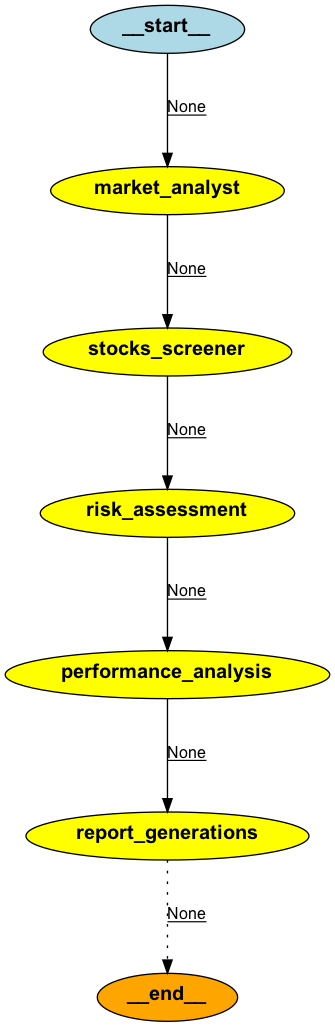

In [24]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

In [25]:
thread = {"configurable": {"thread_id":"1"}}
for s in graph.stream({
    'risk':"High",
    "investment_amount": 200000,
    "investment_time": "5 Years",
    "specific_sectors" : ['Tech', 'Healthcare']
}, thread):
    print(s)

{'market_analyst': {'market_analysis': "As a market analyst, I can't directly use the Tavily API to gather market data as it's a text-based AI model and doesn't fetch real-time data or interact with databases. However, I can certainly provide an analysis based on known trends and general market conditions.\n\nCurrently, the tech and healthcare sectors are performing well, especially due to the acceleration of digital transformation and the global health crisis. However, the risk factor remains high due to the volatile nature of these sectors, global economic conditions, and the ongoing pandemic.\n\nWhen investing a substantial amount like $200,000, it's essential to diversify the investment portfolio. Invest in a mix of blue-chip and growth stocks in both sectors. Blue-chip stocks, which are shares in large, well-established companies with a history of reliable performance, would provide stability. Growth stocks, companies expected to grow at an above-average rate compared to other sto